# If you dont want to train skip step 2,3,5,6


# **Step 1: Clone Repo and install all dependencies**

In [2]:
!git clone https://github.com/ultralytics/yolov5
!pip install -qr yolov5/requirements.txt
%cd yolov5

import torch
from IPython.display import Image, clear_output
from utils.google_utils import gdrive_download

clear_output()

# **Step 2: Download the custom data-set that you are interested in (using the Roboflow api)**  [Link to datasets](https://public.roboflow.com/)

In [ ]:
%cd /content
!curl -L "PASTE YOUR LINK HERE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# **Step 3: Create the custom model configuration file**

In [ ]:
#extracting information from the roboflow file
%cat data.yaml

In [ ]:
# define number of classes based on data.yaml
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

#**Step** **4** : Change configration File

In [ ]:
num_classes = 2

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# **Step 5: Train yolov5 on the custom images using the custom configuration file**

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

#**Step 6: Run yolov5 detection on images.**
# *Don't forget to copy the location of the weights file and replace it in the code below*

In [ ]:
!python detect.py --weights runs/exp0_yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/inference/output/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

#*Step** **7** : Pretrained model

In [3]:
!git clone https://github.com/adeelahmad-co/yoloV5_customObject_mask

Cloning into 'yoloV5_customObject_mask'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [4]:
!python detect.py --weights yoloV5_customObject_mask/mask.pt --img 416 --conf 0.4 --source yoloV5_customObject_mask/salman.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='yoloV5_customObject_mask/salman.jpg', update=False, view_img=False, weights=['yoloV5_customObject_mask/mask.pt'])
Using torch 1.7.0+cu101 CPU

Fusing layers... 
Model Summary: 232 layers, 7249215 parameters, 0 gradients, 16.8 GFLOPS
image 1/1 /content/yolov5/yoloV5_customObject_mask/salman.jpg: 256x416 1 masks, Done. (0.196s)
Results saved to runs/detect/exp
Done. (0.274s)


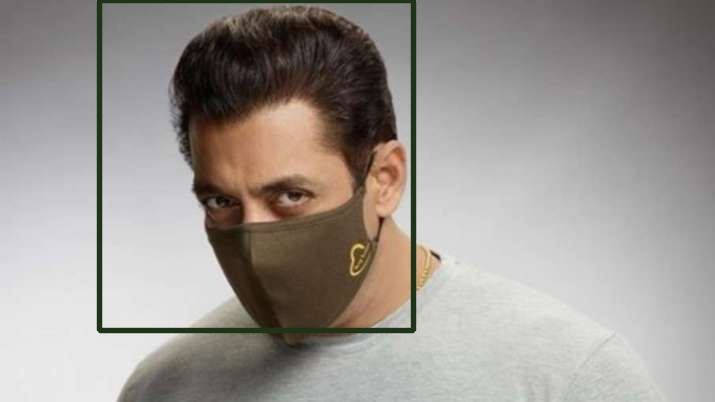

In [5]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

In [ ]:
import base64
import html
import io
import time
 
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2
 
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
 
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
 
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
 
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
 
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
 
    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)
 
    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 32), np.mod(dh, 32)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios
 
    dw /= 2  # divide padding into 2 sides
    dh /= 2
 
    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [ ]:
import argparse
import time
from pathlib import Path
 
import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random
 
from models.experimental import attempt_load
# from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, non_max_suppression, apply_classifier, scale_coords, xyxy2xywh, \
    strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized
 
 
parser = argparse.ArgumentParser()
parser.add_argument('--classes', nargs='+', type=int, help='filter by class')
parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
parser.add_argument('--img-size', type=int, default=416, help='inference size (pixels)')
opt = parser.parse_args(args = [])
 
weights,imgsz = 'yoloV5_customObject_mask/mask.pt',512
 
# Initialize
set_logging()
device = select_device()
half = device.type != 'cpu'  # half precision only supported on CUDA
 
# Load model
model = attempt_load(weights, map_location=device)  # load FP32 model
imgsz = check_img_size(imgsz, s=model.stride.max())  # check img_size
if half:
  model.half()  # to FP16
 
# Second-stage classifier
classify = False
if classify:
  modelc = load_classifier(name='resnet101', n=2)  # initialize
  modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()
 
# Get names and colors
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
 
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
 
    return image_array
 
def get_drawing_array(image_array): 
    """
    input: 
          image_array: image array RGB size 512 x 512 from webcam
 
    output: 
          drawing_array: image RGBA size 512 x 512 only contain bounding box and text, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0
    """
    drawing_array = np.zeros([512,512,4], dtype=np.uint8)
    img = letterbox(image_array, new_shape=imgsz)[0]
 
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
 
    img = torch.from_numpy(img).to(device)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0 # (0 - 255) to (0.0 - 1.0)
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
 
    pred = model(img)[0]
    # Apply NMS
    pred = non_max_suppression(pred,0.3,0.6, classes=opt.classes, agnostic=opt.agnostic_nms)
 
    # Process detections
    det = pred[0]
    if det is not None and len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], image_array.shape).round()
 
        # Write results
        for *xyxy, conf, cls in det:
            label = '%s %.2f' % (names[int(cls)], conf)
            plot_one_box(xyxy, drawing_array, label=label, color=colors[int(cls)])
 
    drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255
 
    return drawing_array
 
def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0
 
    output: 
          drawing_bytes: string, encoded from drawing_array
    """
 
    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

Using torch 1.7.0+cu101 CPU



Fusing layers... 


Model Summary: 232 layers, 7249215 parameters, 0 gradients, 16.8 GFLOPS


In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break
 
    image = js_reply_to_image(js_reply)
    drawing_array = get_drawing_array(image) 
    drawing_bytes = drawing_array_to_bytes(drawing_array)
    img_data = drawing_bytes

<IPython.core.display.Javascript object>